In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from kan import KAN
import torch

In [2]:
# Función para preparar los datos
def prepare_data(data, window_size=2):
    X, y = [], []
    for i in range(window_size, len(data) - 1):
        X.append(data[i-window_size:i].flatten())
        y.append(data[i+1])
    X, y = np.array(X), np.array(y)
    return X, y

In [3]:
# Download historical data for Amazon (AMZN)
ticker = 'AMZN'
data = yf.download(ticker, start='2013-01-01', end='2023-12-31', interval='1d')

# Only keep the 'Open', 'Close', 'Low', and 'High' columns
data = data[['Open', 'Close', 'Low', 'High']]

# Fill missing values using forward fill method
data.fillna(method='ffill', inplace=True)

# Ensure there are no remaining missing values
assert data.isnull().sum().sum() == 0, "There are still missing values in the data"

# Initialize the MinMaxScaler and scale the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Preparar datos de entrenamiento y prueba
X, y = prepare_data(data_scaled)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

[*********************100%%**********************]  1 of 1 completed
C:\Users\Carlo\AppData\Local\Temp\ipykernel_1712\953141569.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
C:\Users\Carlo\AppData\Local\Temp\ipykernel_1712\953141569.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.fillna(method='ffill', inplace=True)


In [4]:
# Inicializar el modelo KAN
model = KAN(width=[8, 16, 12, 8, 4], grid=5, k=3) #model = KAN(width=[8, 2, 2, 4], grid=5, k=3)

# Convertir los datos de numpy a tensores de PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Entrenar el modelo KAN
dataset = {
    'train_input': X_train_tensor,
    'test_input': X_test_tensor,
    'train_label': y_train_tensor,
    'test_label': y_test_tensor
}
model.train(dataset, opt="LBFGS", steps=50)


# Realizar predicciones
predictions_train = model(X_train_tensor).detach().numpy()
predictions_test = model(X_test_tensor).detach().numpy()

train loss: 1.03e-02 | test loss: 2.84e-02 | reg: 7.35e+01 : 100%|██| 50/50 [08:18<00:00,  9.97s/it]


In [5]:
# Transformar datos de vuelta a la escala original
def inverse_transform_all_features(scaler, data_scaled):
    data_inverse = scaler.inverse_transform(data_scaled)
    return data_inverse

train_target_original = inverse_transform_all_features(scaler, y_train)
test_target_original = inverse_transform_all_features(scaler, y_test)
predictions_train_original = inverse_transform_all_features(scaler, predictions_train)
predictions_test_original = inverse_transform_all_features(scaler, predictions_test)

In [6]:
# Asegurarse de que los índices coinciden
train_index = data.index[2:train_size + 2]
test_index = data.index[train_size + 2: train_size + 2 + len(y_test)]

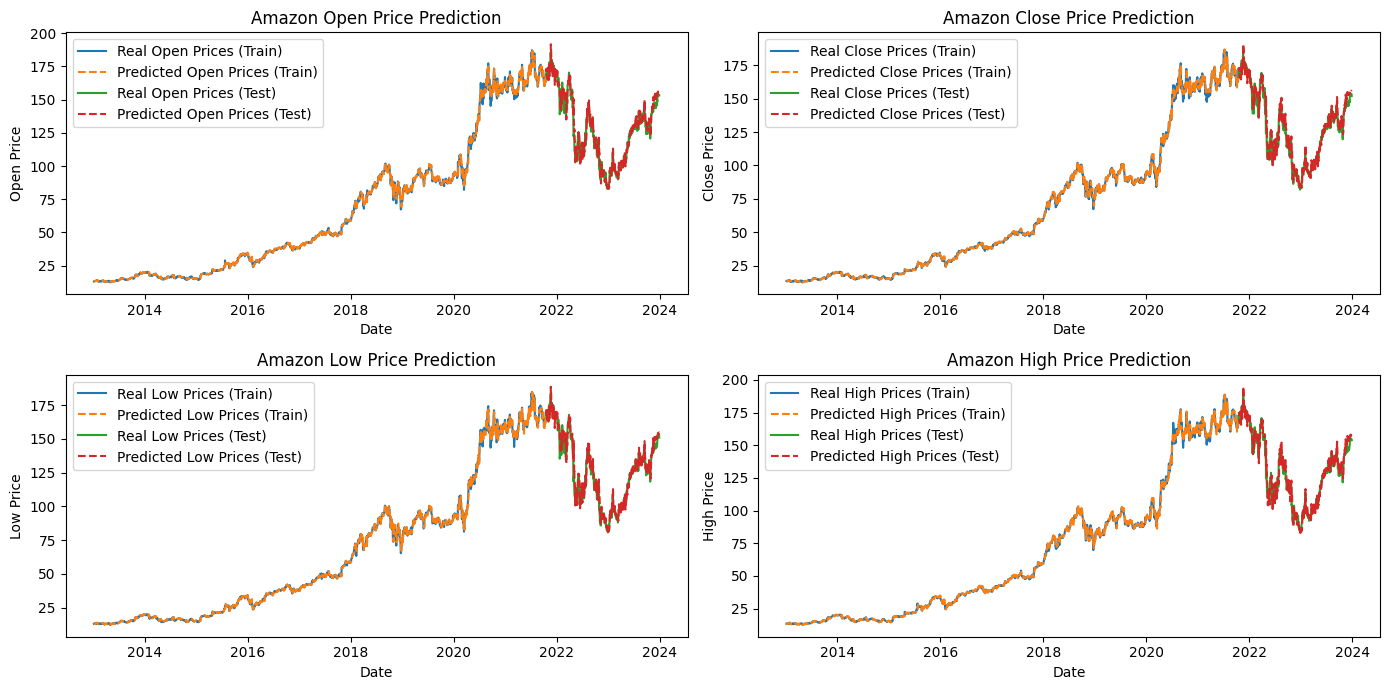

In [7]:
# Graficar los resultados
plt.figure(figsize=(14, 7))

# Gráfica de entrenamiento y prueba para cada característica
for i, col in enumerate(['Open', 'Close', 'Low', 'High']):
    plt.subplot(2, 2, i+1)
    plt.plot(train_index, train_target_original[:, i], label=f'Real {col} Prices (Train)')
    plt.plot(train_index, predictions_train_original[:, i], linestyle='--', label=f'Predicted {col} Prices (Train)')
    plt.plot(test_index, test_target_original[:, i], label=f'Real {col} Prices (Test)')
    plt.plot(test_index, predictions_test_original[:, i], linestyle='--', label=f'Predicted {col} Prices (Test)')
    plt.xlabel('Date')
    plt.ylabel(f'{col} Price')
    plt.title(f'Amazon {col} Price Prediction')
    plt.legend()

plt.tight_layout()
plt.show()

In [8]:
# Function to calculate accuracy
def calculate_accuracy(y_true, y_pred):
    with torch.no_grad():
        accuracy = torch.mean(1 - torch.abs(y_true - y_pred) / y_true)
    return accuracy.item()

accuracy_test = calculate_accuracy(y_test_tensor, model(X_test_tensor))

print(f'Accuracy (Test): {accuracy_test * 100:.2f}%')

Accuracy (Test): 96.75%


In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate additional metrics
mse_train = mean_squared_error(train_target_original, predictions_train_original)
mae_train = mean_absolute_error(train_target_original, predictions_train_original)
r2_train = r2_score(train_target_original, predictions_train_original)

mse_test = mean_squared_error(test_target_original, predictions_test_original)
mae_test = mean_absolute_error(test_target_original, predictions_test_original)
r2_test = r2_score(test_target_original, predictions_test_original)

print(f'MSE (Train): {mse_train:.4f}')
print(f'MSE (Test): {mse_test:.4f}')
print(f'MAE (Train): {mae_train:.4f}')
print(f'MAE (Test): {mae_test:.4f}')
print(f'R^2 (Train): {r2_train:.4f}')
print(f'R^2 (Test): {r2_test:.4f}')

MSE (Train): 3.1982
MSE (Test): 24.4559
MAE (Train): 1.0507
MAE (Test): 3.6880
R^2 (Train): 0.9987
R^2 (Test): 0.9613


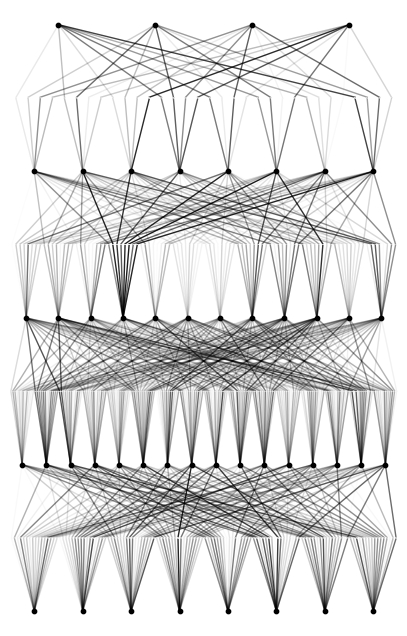

In [10]:
model.plot()